# Two-point statistics from *Heracles*

This notebook demonstrates how *Heracles* extracts the two-point statistics from a 3×2pt catalogue.

<div class="alert alert-info">

**Important note**

This notebook is only meant to give you an idea of **how *Heracles* works**.

It does **not** show everything that *Heracles* can do.

**This is a toy, treat it is such!**

</div>

## Setup

Some required imports, nothing fancy.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl

Now the *Heracles* imports:

* The top-level `heracles` module contains all general user-facing functionality.
* The `heracles.healpy` module contains mappers based on the `healpy` package.
* The `heracles.notebook` module contains a progress bar based on the `ipywidgets` package.

In [2]:
import heracles
import heracles.healpy
from heracles.notebook import Progress

If there is an import error on the last line of the previous block, it means you need to install the `ipywidgets` package.

## Data set

The example uses a prepared [*example data set*](https://dx.doi.org/10.5281/zenodo.13622598). The catalogue contains about 75 million galaxies over a contiguous 5% of the sky.

To download the example data, run the following cell.

In [3]:
import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

## Basic parameters

This is the resolution parameter for measuring spectra from *HEALPix* maps.  Here, we use `nside = 1024` since that is the resolution at which the example data has been created. A value `lmax` of approximate 1.5x `nside` is fairly safe in terms of errors introduced by *HEALPix*.

In [4]:
nside = 128
lmax = 150

## Catalogues

*Heracles* provides a flexible interface for loading catalogues from FITS files or arrays. It also provides a base class that can quickly be extended, e.g., to databases or more.

Here we use the FITS interface to read a catalogue from file. We could specify the columns to read, but the example catalogue does not have much more than we need here.

Importantly, catalogues are never read into memory all at once. Their `page_size` attribute determines how many rows are read at a time.

In [5]:
# load the FITS catalogue
catalog = heracles.FitsCatalog("catalog.fits")

Using the `catalog.add_filter()` method, we could add filters to the catalogue here, e.g., to strip rows with invalid values, or apply an extra mask.

### Playground

The `Catalog` interface essentially provides an iterator over pages of rows. You can use it as such:

In [6]:
nrows = 0
for page in catalog:
    nrows += page.size

# no need to iterate to get the number of rows, really
assert nrows == catalog.size

print(f"there are {nrows:_} rows in your catalogue")

there are 76_889_615 rows in your catalogue


The `page` object is a mapping of column names to rows, with some additional features:

* The number of rows, `page.size`
* The names of columns, `page.names`
* A view of the underlying data, `page.data`
* Make a copy of the page, `page.copy()`
* Delete specific rows, `page.delete(where)`
* Return multiple columns at once, using `page['a', 'b']` or `page[['a', 'b']]`
* Return columns while checking for invalid values, using `page.get('a', 'b')`

## Visibility maps

The statistics of galaxy positions require knowledge of the a priori probability of detecting a galaxy at each point in the sky. We call this the *visibility*, and we use it in the form of a *visibility maps*, which is a full-sky maps of detection probabilities.

In [7]:
vmap = hp.read_map("vmap.fits.gz")

# fix UNSEEN pixels to zero and rescale to nside
vmap[vmap == hp.UNSEEN] = 0.0
vmap = hp.ud_grade(vmap, 2 * nside)

For a real survey, the visibility is a complicated function of position, observing conditions, selection, and tomographic bin. However, in this simulated example, the selection is the same for all positions and tomographic bins, and the visibility map is simply the footprint map of the survey.

In [8]:
# set visibility map of entire catalogue
catalog.visibility = vmap

### Playground

Quick inspection of the visibility map:

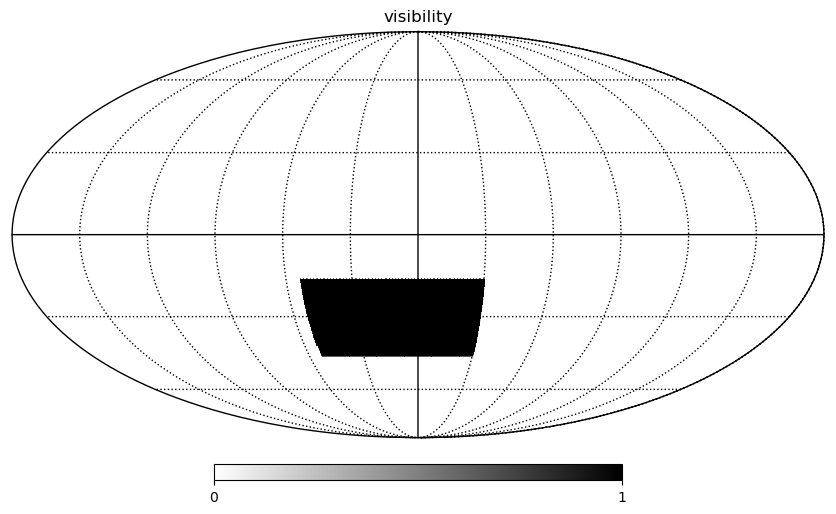

In [9]:
hp.mollview(vmap, title="visibility", cmap="binary", bgcolor="none")
hp.graticule()
plt.show()

## Tomographic binning

The `catalog` object can be used to read the entire catalogue. Of course, we would like to split our galaxies into individual tomographic bins. In the example data set, each galaxy has already been assigned a label for its tomographic bin, in the `"BIN"` column.

To perform the tomographic binning, we construct a dictionary that assigns an integer bin ID to a selection from the catalogue for each tomographic bin. This is done using the usual `[]` indexing syntax, which returns a new view of the `FitsCatalog` with the given selection applied.

In [10]:
catalogs = {i: catalog[f"BIN == {i}"] for i in range(1, 3)}

In [11]:
catalogs

{1: catalog.fits['BIN == 1'], 2: catalog.fits['BIN == 2']}

Catalogue views (i.e., selections) have their own individual `visibility`, and inherit the visibility of the base catalogue by default.

Instead of the `[]` syntax, views can also be created using the `catalog.where()` method, where the visibility can be given as a parameter.

In [13]:
catalogs[2].visibility is vmap

True

Note that `catalogs` is a simple mapping of integer bin IDs to instances of type `Catalog`. You can create such a mapping in any way you like; the values do not have to come from the same `FitsCatalog`, or even the same type of catalogue.

### Playground

Return the number of rows in tomographic bin 5.

In [16]:
# need to sum because FITS cannot tell the size a priori
nrows = sum(page.size for page in catalogs[2])

print(f"tomographic bin 5 contains {nrows:_} rows")

tomographic bin 5 contains 12_791_391 rows


## Fields

To turn catalogues into spectra, *Heracles* requires a so-called mapper object that knows how to turn positions and values into spherical functions.
Here, we construct a `HealpixMapper` instance with our desired `nside` and `lmax` parameters.
When computing spherical harmonic coefficients, the *HEALPix* mapper will also remove the pixel window function, unless `deconvolve=False` is passed.

In [17]:
mapper = heracles.healpy.HealpixMapper(nside, lmax)

To specify the fields we wish to analyse, we construct a dictionary of keys and field definitions.
Each field receives a mapper and a list of columns that it reads, plus potentially some other options.

For a standard 3×2pt analysis in harmonic space, we need

* A position field (`"POS"`) for angular clustering and galaxy-galaxy lensing;
* A shear field (`"SHE"`) for cosmic shear and galaxy-galaxy lensing.

When passing the column names, we could specify that the shear field should flip the sign of a column by adding a minus sign (e.g., `"-E2"` to flip the second shear component).  However, we do not need to do that here.

Finally, we define the optional names of the masks (`"VIS"`, `"WHT"`) of the fields. These will be used further down below to compute mixing matrices.

In [18]:
fields = {
    "POS": heracles.Positions(
        mapper,
        "RA",
        "DEC",
        mask="VIS",
    ),
    "SHE": heracles.Shears(
        mapper,
        "RA",
        "DEC",
        "E1",
        "E2",
        "W",
        mask="WHT",
    ),
}

## Mapping

The next step is to map the catalogues to position and shear fields for each tomographic bin. *Heracles* can map a set of catalogues all at once, using the `map_catalogs()` functions. We only need to pass in the fields and catalogues constructed previously.

If there is enough memory to hold _all_ maps in memory at the same time, we can use `parallel=True` to construct maps for all entries in `catalogs` (i.e., tomographic bins) at the same time. Here, this has the advantage of reading the entire FITS file only once.

In [19]:
with Progress("mapping") as progress:
    data = heracles.map_catalogs(fields, catalogs, parallel=True, progress=progress)

VBox()

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/heracles/fields.py:302: UserWarning: positions and visibility have different size
  warnings.warn("positions and visibility have different size")


The resulting `data` object is a dictionary with keys corresponding to each field (`"POS"`, `"SHE"`) and catalogue (`0`, `1`, ...). Results from *Heracles* are always of this form.

In [20]:
list(data.keys())[:6] + ["..."]

[('POS', 1), ('SHE', 1), ('POS', 2), ('SHE', 2), '...']

### Playground

Since the *HEALPix* mapper produces actual maps, we can take a quick look at the data for a tomographic bin ID, say 3.

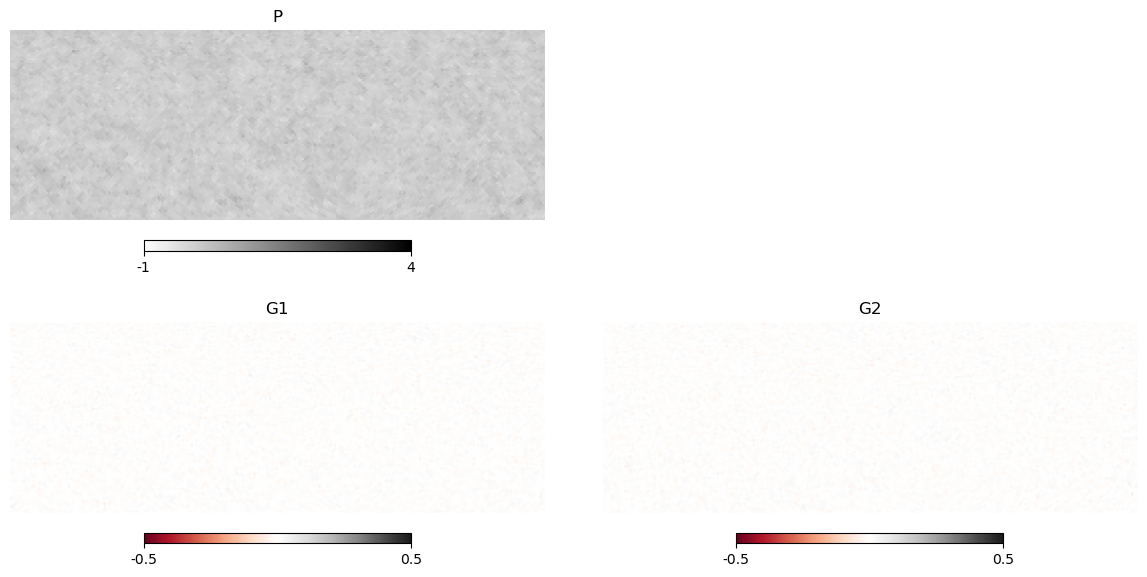

In [23]:
i = 1

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout()
plt.sca(ax[0, 0])
hp.cartview(
    data["POS", i],
    title="P",
    cmap="binary",
    min=-1.0,
    max=4.0,
    hold=True,
    lonra=[329.5, 53.5],
    latra=[-45.6, -15.7],
)
ax[0, 1].axis("off")
plt.sca(ax[1, 0])
hp.cartview(
    data["SHE", i][0],
    title="G1",
    cmap="RdGy",
    min=-0.5,
    max=0.5,
    hold=True,
    lonra=[329.5, 53.5],
    latra=[-45.6, -15.7],
)
plt.sca(ax[1, 1])
hp.cartview(
    data["SHE", i][1],
    title="G2",
    cmap="RdGy",
    min=-0.5,
    max=0.5,
    hold=True,
    lonra=[329.5, 53.5],
    latra=[-45.6, -15.7],
)
plt.show()

## Alms

Since we are working in harmonic space, the real-space maps we created so far are not what we are actually after. We therefore transform the data into harmonic space (i.e. $a_{lm}$) using the `transform()` function.

In [24]:
with Progress("transform") as progress:
    alms = heracles.transform(fields, data, progress=progress)

VBox()

The resulting `alms` dictionary has the same keys as `data`, but contains the spherical harmonic coefficients of the maps.

In [25]:
list(alms.keys())[:6] + ["..."]

[('POS', 1), ('SHE', 1), ('POS', 2), ('SHE', 2), '...']

## Two-point statistics

We are now able to compute two-point statistics in the form of angular power spectra.
To do so, we simply call the `angular_power_spectra()` function on `alms`.
The function will automatically remove the noise bias from the spectra (unless `debias=False` is passed), and can optionally compute binned spectra (by passing the `bins=` and `weights=` parameters).

In [26]:
cls = heracles.angular_power_spectra(alms)

This computes the angular power spectra for all *alms* combinations. They are very many, arranged into the familiar dictionary format with entries such as `("POS", "SHE", 5, 4)` for the position and shear cross-spectrum for bins 5 and 4 (in order).

In [27]:
list(cls.keys())[:6] + ["..."] + list(cls.keys())[-6:]

[('POS', 'POS', 1, 1),
 ('POS', 'SHE', 1, 1),
 ('POS', 'POS', 1, 2),
 ('POS', 'SHE', 1, 2),
 ('SHE', 'SHE', 1, 1),
 ('POS', 'SHE', 2, 1),
 '...',
 ('SHE', 'SHE', 1, 1),
 ('POS', 'SHE', 2, 1),
 ('SHE', 'SHE', 1, 2),
 ('POS', 'POS', 2, 2),
 ('POS', 'SHE', 2, 2),
 ('SHE', 'SHE', 2, 2)]

## Mixing matrices

We usually do not have data over the entire sky, but are limited by the survey footprint and visibility.
This affects the harmonic-space two-point statistics, and is modelled by the so-called mixing matrices.

Computing the mixing matrices requires additional computation for the visibility and shear weights in each tomographic bin.
Square mixing matrices up to `lmax` require input spectra with 2x `lmax`, for which we create a new *HEALPix* mapper at twice the resolution.

In [28]:
mapper2 = heracles.healpy.HealpixMapper(2 * nside, 2 * lmax)

We now use the same catalogues to map the visibility and weights, using the `map_catalogs()` function as before.

Since each field gets its own mapper, we could also have computed all maps in one go.

In [29]:
# visibility maps are taken as-is from catalogue, so no columns
vis_fields = {
    "VIS": heracles.Visibility(
        mapper2,
    ),
    "WHT": heracles.Weights(
        mapper2,
        "RA",
        "DEC",
        "W",
    ),
}

with Progress("mapping") as progress:
    vis_maps = heracles.map_catalogs(
        vis_fields, catalogs, parallel=True, progress=progress
    )

VBox()

The `vis_maps` output has the same format as earlier, but now contains `"VIS"` and `"WHT"` maps as expected.

In [30]:
list(vis_maps.keys())[:6] + ["..."]

[('VIS', 1), ('WHT', 1), ('VIS', 2), ('WHT', 2), '...']

Next we transform the maps for the mixing matrices ...

In [31]:
with Progress("transform") as progress:
    vis_alms = heracles.transform(vis_fields, vis_maps, progress=progress)

VBox()

... and compute their angular power spectra.

In [32]:
vis_cls = heracles.angular_power_spectra(vis_alms)

With the angular power spectra of visibility and weight maps available, we can compute all mixing matrices with the `mixing_matrices()` function.
It can optionally compute mixing matrices for binned spectra, by providing the `bins=` and `weights=` parameters.

In [33]:
with Progress("mixmats") as progress:
    mms = heracles.mixing_matrices(
        fields, vis_cls, l1max=lmax, l2max=lmax, progress=progress
    )

VBox()

The mixing matrices are returned in a dictionary with names matching the angular power spectra:

* `("POS", "POS", i, j)` contains the $M^{TT,TT}$ mixing matrix;
* `("POS", "SHE", i, j)` contains the $M^{TE,TE} = M^{TB,TB}$ mixing matrix;
* `("SHE", "SHE", i, j)` contains the stack of mixing matrices
  
  * $M^{EE,EE} = M^{BB,BB}$,
  * $M^{EE,BB} = M^{BB,EE}$,
  * $M^{EB,EB}$.

For more details on mixing matrices in general, see, e.g., the paper by Brown, Castro & Taylor (2005).

In [34]:
list(mms.keys())[:6] + ["..."] + list(mms.keys())[-6:]

[('POS', 'POS', 1, 1),
 ('POS', 'SHE', 1, 1),
 ('POS', 'POS', 1, 2),
 ('POS', 'SHE', 1, 2),
 ('SHE', 'SHE', 1, 1),
 ('POS', 'SHE', 2, 1),
 '...',
 ('SHE', 'SHE', 1, 1),
 ('POS', 'SHE', 2, 1),
 ('SHE', 'SHE', 1, 2),
 ('POS', 'POS', 2, 2),
 ('POS', 'SHE', 2, 2),
 ('SHE', 'SHE', 2, 2)]

### Playground

As before, the mapper has produced *HEALPix* maps, so we can have a look at the visibility and weight map for bin ID 3, say.

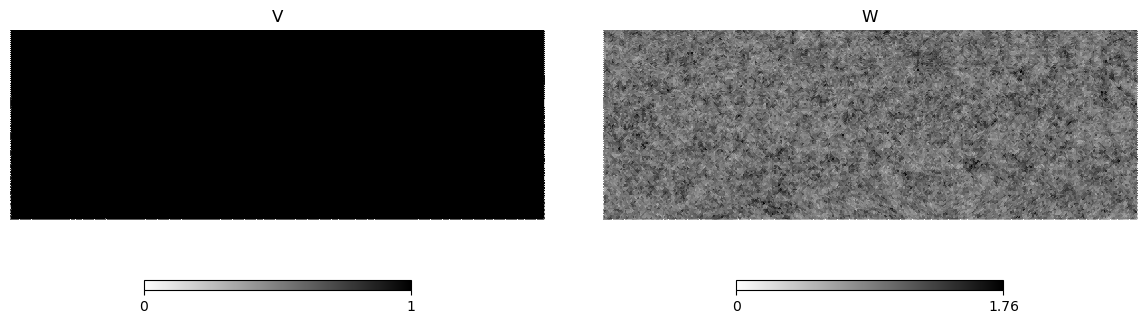

In [36]:
i = 2

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig.tight_layout()
plt.sca(ax[0])
hp.cartview(
    vis_maps["VIS", i],
    title="V",
    cmap="binary",
    hold=True,
    lonra=[329.5, 53.5],
    latra=[-45.6, -15.7],
)
plt.sca(ax[1])
hp.cartview(
    vis_maps["WHT", i],
    title="W",
    cmap="binary",
    hold=True,
    lonra=[329.5, 53.5],
    latra=[-45.6, -15.7],
)
plt.show()

And here is the corresponding `("SHE", "SHE", i, i)` mixing matrix $M^{EE,EE}$:

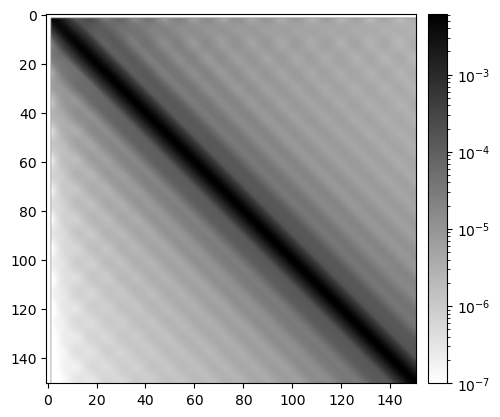

In [37]:
plt.imshow(
    mms["SHE", "SHE", i, i][0], cmap="binary", norm=mpl.colors.LogNorm(vmin=1e-7)
)
plt.colorbar(pad=0.025, fraction=0.0465)
plt.show()

## Theory

To model the expected angular power spectra, we require the mixing matrices and the expected full-sky angular power spectra from theory.
Here, we use *CAMB* to compute the latter.

In [38]:
import camb
from camb.sources import SplinedSourceWindow

We set the *CAMB* cosmology to match the simulation that created the example data set.

In [39]:
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h, omch2=Oc * h**2, ombh2=Ob * h**2, NonLinear=camb.model.NonLinear_both
)
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

We also need the redshift distributions for the tomographic bins.

In [40]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

Given the redshift distributions, we can construct the *CAMB* source distributions for positions (counts) and shears (lensing).

In [41]:
sources = []
for i, nz_i in enumerate(nz):
    sources += [
        SplinedSourceWindow(source_type="counts", z=z, W=nz_i),
        SplinedSourceWindow(source_type="lensing", z=z, W=nz_i),
    ]
pars.SourceWindows = sources

Use the `pars` we constructed above to compute the full sky theory spectra up to `lmax`, setting `raw_cl=True` to return unscaled full-sky spectra.

In [42]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

This is the factor needed to convert from the convergence spectra returned by *CAMB* to shear *E*-mode spectra.

In [43]:
ell = np.arange(lmax + 1)
fl = -np.sqrt((ell + 2) * (ell + 1) * ell * (ell - 1))
fl /= np.clip(ell * (ell + 1), 1, None)

Now we can compute the theory spectra for our observations, using the *CAMB* results and the mixing matrices we computed earlier. We store everything in dictionary using the same format as before.

In [55]:
theory = {}
for i in range(1, 3):
    for j in range(i, 3):
        # get the full-sky spectra; B-mode is assumed zero
        cl_pp = camb_cls[f"W{2 * i - 1}xW{2 * j - 1}"]
        cl_pe = fl * camb_cls[f"W{2 * i - 1}xW{2 * j}"]
        cl_pb = np.zeros_like(cl_pe)
        cl_ep = fl * camb_cls[f"W{2 * i}xW{2 * j - 1}"]
        cl_bp = np.zeros_like(cl_ep)
        cl_ee = fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"]
        cl_bb = np.zeros_like(cl_ee)
        cl_eb = np.zeros_like(cl_ee)
        cl_be = np.zeros_like(cl_ee)

        # all mixing matrix combinations
        theory["POS", "POS", i, j] = mms["POS", "POS", i, j] @ cl_pp
        theory["POS", "SHE", i, j] = np.stack(
            [
                mms["POS", "SHE", i, j] @ cl_pe,
                mms["POS", "SHE", i, j] @ cl_pb,
            ]
        )
        theory["POS", "SHE", j, i] = np.stack(
            [
                mms["POS", "SHE", j, i] @ cl_ep,
                mms["POS", "SHE", j, i] @ cl_bp,
            ]
        )
        theory["SHE", "SHE", i, j] = np.stack(
            [
                mms["SHE", "SHE", i, j][0] @ cl_ee + mms["SHE", "SHE", i, j][1] @ cl_bb,
                mms["SHE", "SHE", i, j][0] @ cl_bb + mms["SHE", "SHE", i, j][1] @ cl_ee,
                mms["SHE", "SHE", i, j][2] @ cl_eb,
                mms["SHE", "SHE", i, j][2] @ cl_be,
            ]
        )

## Results

Finally, we can plot the results for positions and shears.

In [56]:
ell = np.arange(lmax + 1)

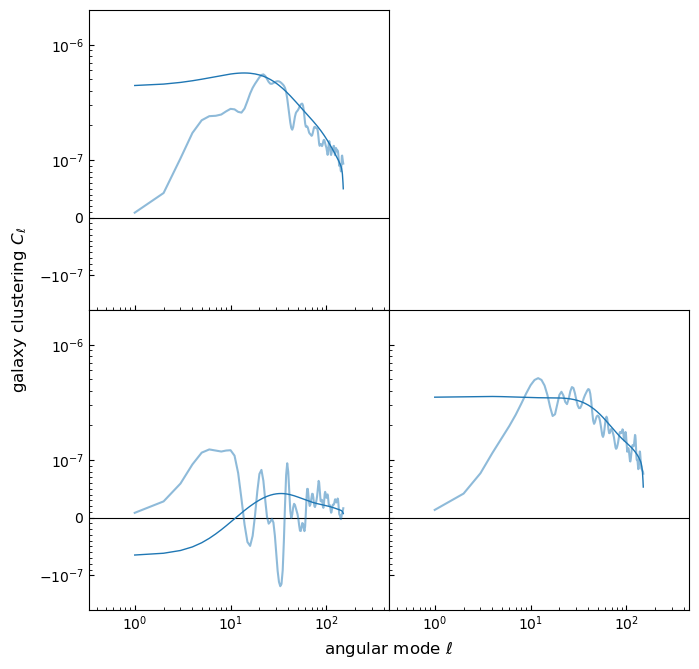

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, 3):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, 3):
        ax[j - 1, i - 1].plot(
            ell[1:], cls["POS", "POS", i, j][1:], c="C0", lw=1.5, zorder=3.0, alpha=0.5
        )
        ax[j - 1, i - 1].plot(
            ell[1:], theory["POS", "POS", i, j][1:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-2e-7, 2e-6)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

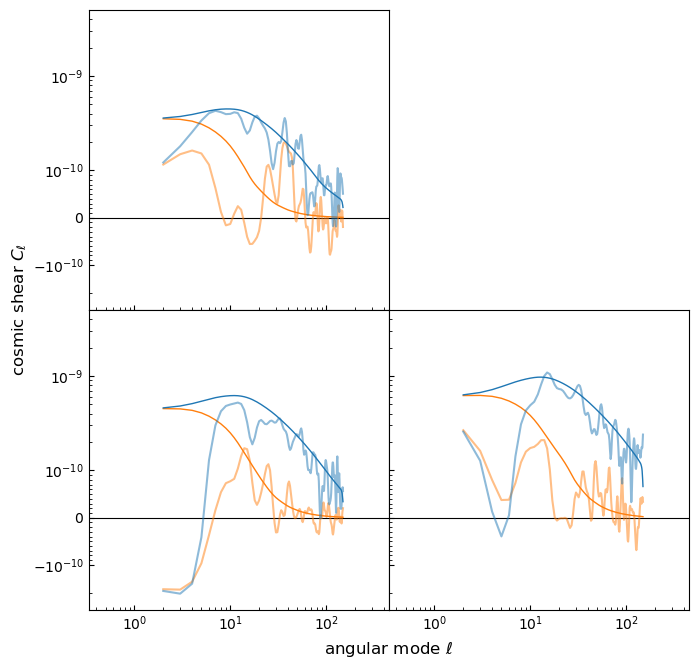

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, 3):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, 3):
        ax[j - 1, i - 1].plot(
            ell[2:],
            cls["SHE", "SHE", i, j][0, 2:],
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["SHE", "SHE", i, j][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].plot(
            ell[2:],
            cls["SHE", "SHE", i, j][1, 2:],
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["SHE", "SHE", i, j][1, 2:], c="C1", lw=1.0, zorder=2.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3e-10, 5e-9)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

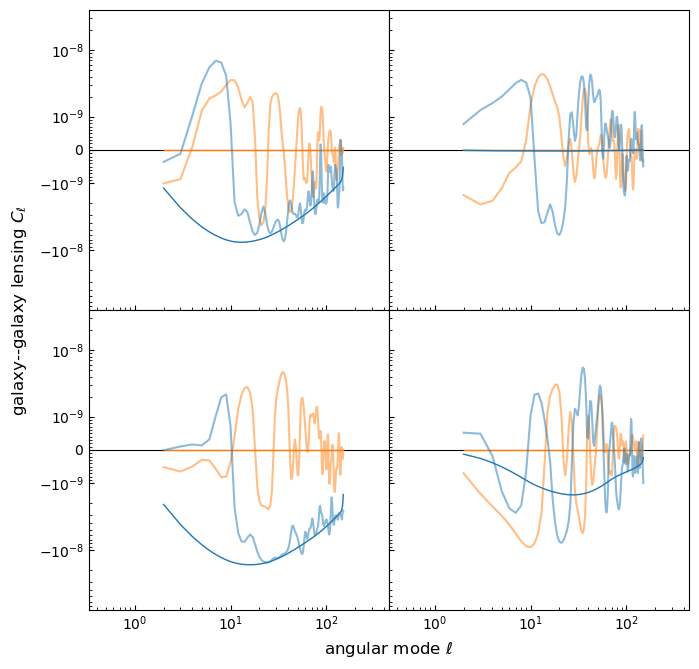

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, 3):
    for j in range(1, 3):
        ax[j - 1, i - 1].plot(
            ell[2:],
            cls["POS", "SHE", i, j][0, 2:],
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["POS", "SHE", i, j][0, 2:], c="C0", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].plot(
            ell[2:],
            cls["POS", "SHE", i, j][1, 2:],
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[j - 1, i - 1].plot(
            ell[2:], theory["POS", "SHE", i, j][1, 2:], c="C1", lw=1.0, zorder=2.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-8e-8, 4e-8)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()

## Output

Additionally, we can write the data we produced to file.

In [62]:
heracles.write("example-spectra.fits", cls, clobber=True)
heracles.write("example-mixmats.fits", mms, clobber=True)

## Covariance

In [105]:
import skysegmentor
import heracles.dices as dices

In [106]:
jk_maps = {}
Njk = 5
vmap = hp.ud_grade(vmap, nside)
jk_map = skysegmentor.segmentmapN(vmap, Njk)
for key in list(vis_maps.keys()):
    jk_maps[key] = jk_map

In [107]:
for key in list(vis_maps.keys()):
    vis_maps[key] = hp.ud_grade(vis_maps[key], nside)

In [108]:
print("jkmap: ", len(vmap))
print("vismaps: ", len(vis_maps["VIS", 1]))
print("data: ", len(data["POS", 1]))

jkmap:  196608
vismaps:  196608
data:  196608


In [109]:
for key in list(vis_cls.keys()):
    vis_cls[key] = vis_cls[key][: lmax + 1]

In [110]:
# Shouldn't be needed it
cls0, mls0 = dices.get_cls(data, vis_maps)
# cls0, mls0 = cls, vis_cls

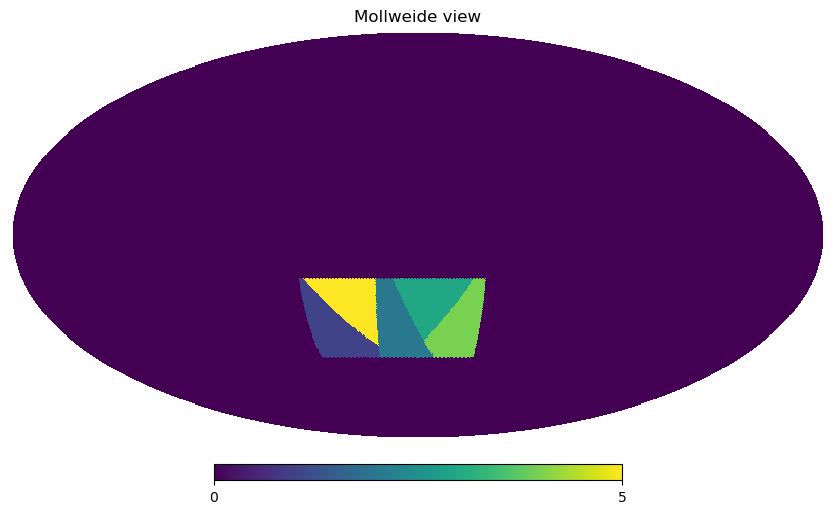

In [111]:
hp.mollview(jk_maps[("VIS", 1)])

In [112]:
cls1 = {}
for jk in range(1, Njk + 1):
    _cls, _cls_mm = dices.get_delete_cls(
        data,
        vis_maps,
        jk_maps,
        jk,
        jk,
    )
    # Mask correction
    _cls = dices.correct_mask(_cls, _cls_mm, vis_cls)

    # Bias correction
    _cls = dices.correct_bias(
        _cls,
        jk_maps,
        jk,
        jk,
    )
    cls1[(jk, jk)] = _cls

In [113]:
(
    shrunk_delete1_cov,
    delete1_cov,
    target_cov,
) = dices.get_delete1_cov(
    cls0,
    cls1,
    shrink=False,
)

Shrinkage intensity not implemented for unbinned Cls
Shrinkage intensity = 0.0000


In [114]:
cls2 = {}
for jk in range(1, Njk + 1):
    for jk2 in range(jk + 1, Njk + 1):
        _cls, _cls_mm = dices.get_delete_cls(
            data,
            vis_maps,
            jk_maps,
            jk,
            jk2,
        )
        # Mask correction
        _cls = dices.correct_mask(_cls, _cls_mm, vis_cls)

        # Bias correction
        _cls = dices.correct_bias(
            _cls,
            jk_maps,
            jk,
            jk2,
        )
        cls2[(jk, jk2)] = _cls

In [115]:
delete2_correction = dices.get_delete2_correction(
    cls0,
    cls1,
    cls2,
)
delete2_cov = dices.get_delete2_cov(delete1_cov, delete2_correction)

In [116]:
dices_cov = dices.get_dices_cov(cls0, delete1_cov, delete2_cov)

In [117]:
ls = np.arange(lmax + 1)

In [118]:
cls0 = dices.compsep_Cls(cls0)
for key in list(cls1.keys()):
    cls1[key] = dices.compsep_Cls(cls1[key])
for key in list(cls2.keys()):
    cls2[key] = dices.compsep_Cls(cls2[key])

In [122]:
_cls1 = {}
for key in list(cls1[(1, 1)].keys()):
    _cls = []
    for i in range(1, Njk + 1):
        cl = cls1[(i, i)][key]
        _cls.append(cl)
    _cls1[key] = np.array(_cls)

_cls2 = {}
for key in list(cls2[(1, 2)].keys()):
    _cls = []
    for i in range(1, Njk + 1):
        for j in range(i + 1, Njk + 1):
            cl = cls2[(i, j)][key]
            _cls.append(cl)
    _cls2[key] = np.array(_cls)

# _cls2 = _cls1

cls1_m = {}
cls1_s = {}
cls2_m = {}
cls2_s = {}
for key in list(_cls1.keys()):
    cls1_m[key] = np.mean(_cls1[key], axis=0)
    cls1_s[key] = np.std(_cls1[key], axis=0)
    cls2_m[key] = np.mean(_cls2[key], axis=0)
    cls2_s[key] = np.std(_cls2[key], axis=0)

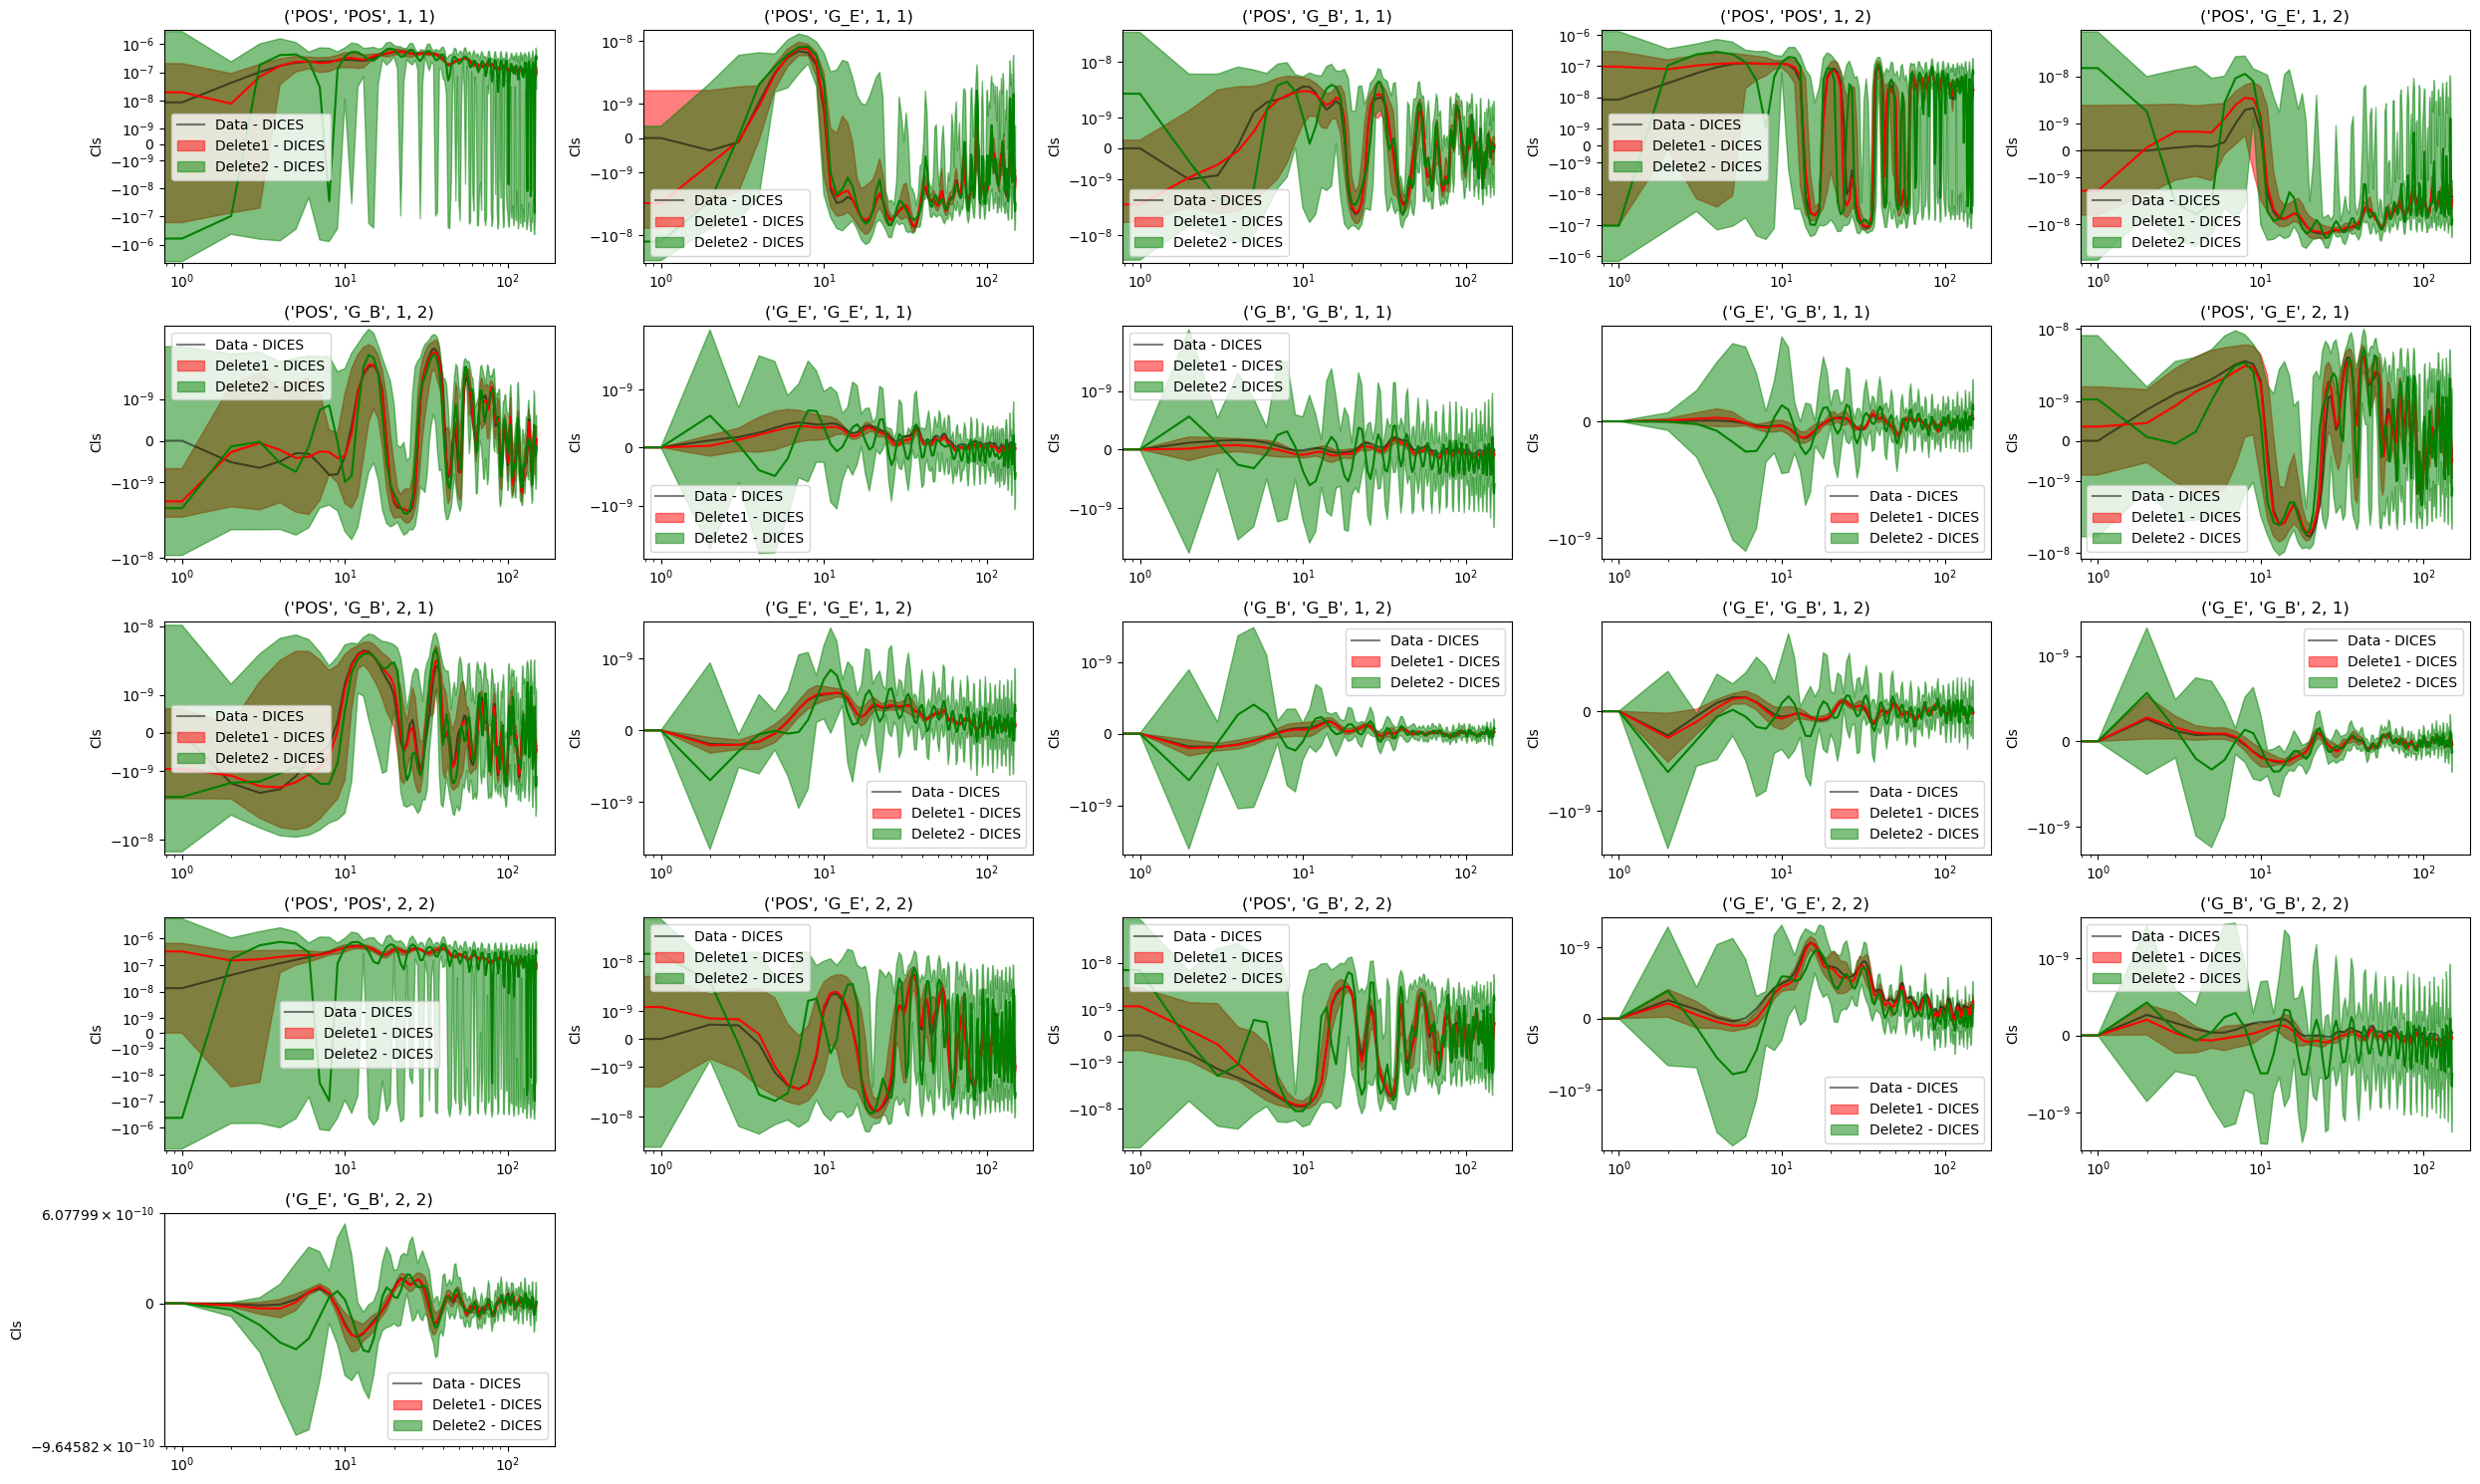

In [123]:
import math

# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for ax, key in zip(axes, cls1_m.keys()):
    a, b, na, nb = key
    # _vcl = _theory_cls[key]
    _cl = cls0[key]
    cl1m = cls1_m[key]
    cl1s = cls1_s[key]
    cl2m = cls2_m[key]
    cl2s = cls2_s[key]
    # ax.plot(ls, _vcl, 'b--', alpha=0.5, label='Theory')
    ax.plot(ls, _cl, "k-", alpha=0.5, label="Data - DICES")
    ax.plot(ls, cl1m, "r-")
    ax.fill_between(
        ls, cl1m - cl1s, cl1m + cl1s, color="r", alpha=0.5, label="Delete1 - DICES"
    )
    ax.plot(ls, cl2m, "g-")
    ax.fill_between(
        ls, cl2m - cl2s, cl2m + cl2s, color="g", alpha=0.5, label="Delete2 - DICES"
    )
    ax.legend()
    ax.set_title(f"{key}")
    ax.set_ylabel("Cls")
    ax.set_xscale("log")
    ax.set_yscale("symlog", linthresh=1e-9, linscale=0.5)

# Hide any unused subplots
for ax in axes[len(cls1_m) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()

/tmp/ipykernel_225639/1600461529.py:21: RuntimeWarning: invalid value encountered in sqrt
  c2err = np.sqrt(np.diag(c2))


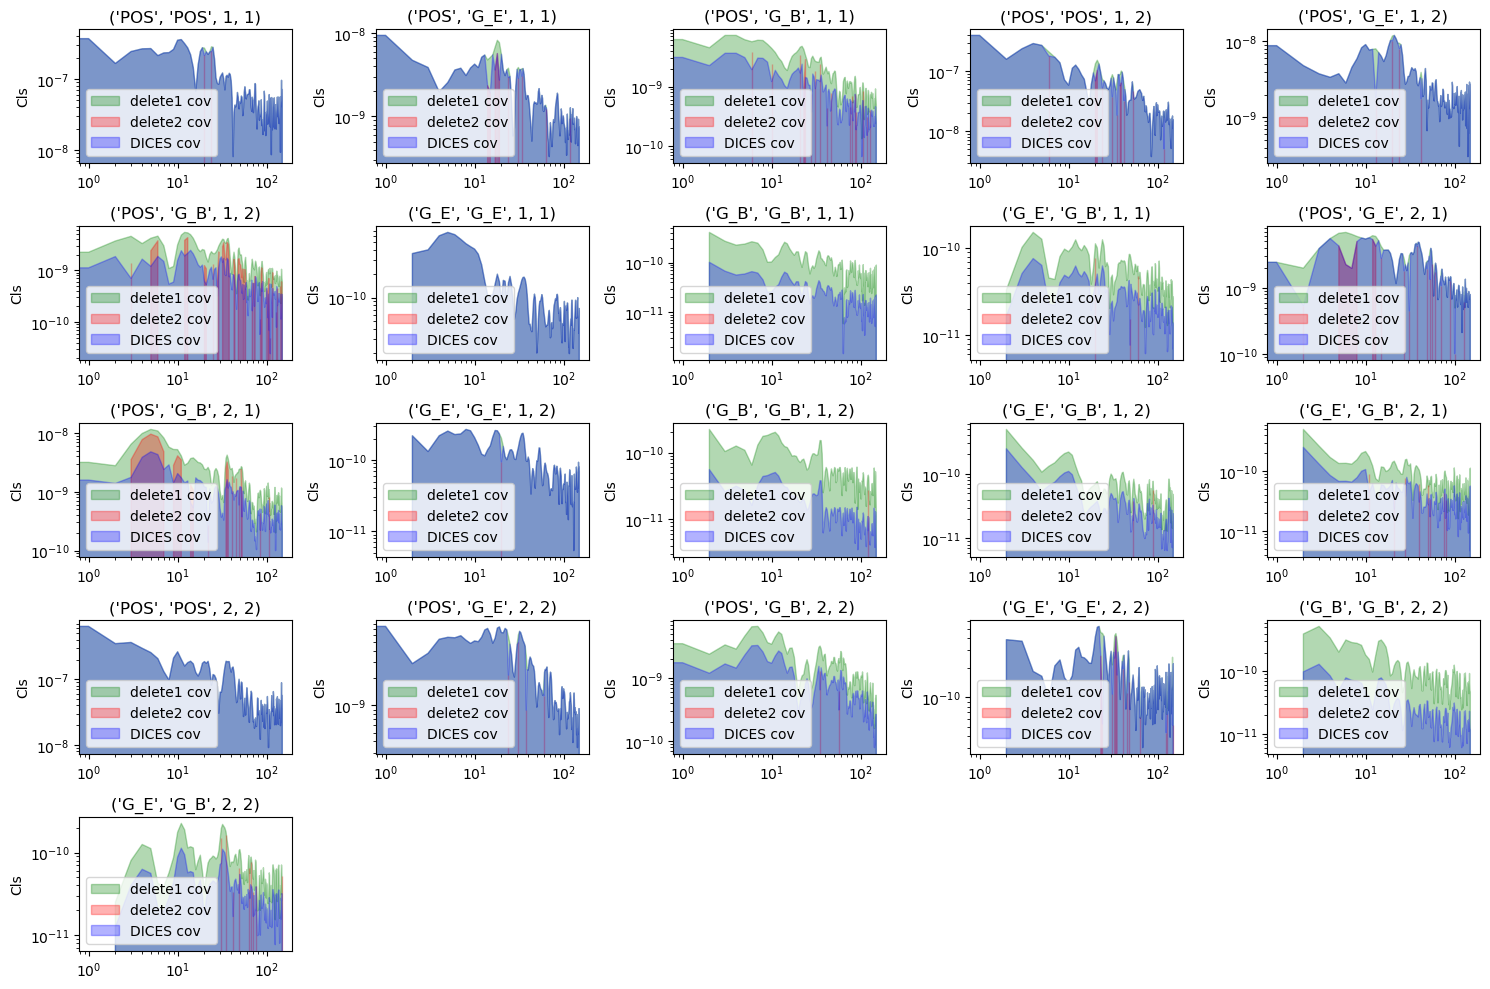

In [124]:
# Determine the number of subplots needed
num_plots = len(cls1_m)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each Cls with error bars
for ax, (key, value) in zip(axes, cls1_m.items()):
    f1, f2, b1, b2 = key
    kk = (f1, f2, f1, f2, b1, b2, b1, b2)
    # _vcl = _theory_cls[key].__array__()
    c = delete1_cov[kk]
    c2 = delete2_cov[kk]
    dc = dices_cov[kk]
    # vc = vcov[kk]
    err = np.sqrt(np.diag(c))
    c2err = np.sqrt(np.diag(c2))
    dcerr = np.sqrt(np.diag(dc))
    # verr = np.sqrt(vc)
    if f1 == "G_B":
        dcerr /= 2
    if f2 == "G_B":
        dcerr /= 2
    # ax.plot(ls, verr, 'k--', lw=3,label='Gaussian Error w/ bias')
    ax.fill_between(
        ls, np.zeros_like(ls), err, color="green", alpha=0.3, label="delete1 cov"
    )
    ax.fill_between(
        ls, np.zeros_like(ls), c2err, color="red", alpha=0.3, label="delete2 cov"
    )
    ax.fill_between(
        ls, np.zeros_like(ls), dcerr, color="blue", alpha=0.3, label="DICES cov"
    )

    ax.set_title(f"{key}")
    ax.legend()
    ax.set_ylabel("Cls")
    ax.loglog()

# Hide any unused subplots
for ax in axes[len(cls1_m) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()